### 사용자 정의 학습

이번 튜토리얼은 붓꽃의 품종을 *분류*하기 위한 머신러닝 모델을 구축할 것입니다. 다음을 위해 텐서플로를 사용합니다.
1. 모델 구축
2. 모델 훈련
3. 모델을 사용한 예측

### 텐서플로 프로그래밍
다음과 같은 고수준 텐서플로의 개념을 사용합니다.

* 텐서플로의 [즉시 실행(eager execution)](https://www.tensorflow.org/guide/eager) 기본 개발 환경 사용,
* [데이터셋 API](https://www.tensorflow.org/guide/datasets)를 활용한 데이터 가져오기,
* [케라스 API](https://keras.io/getting-started/sequential-model-guide/)를 활용한 모델과 층(layer) 구축 .

이번 튜토리얼은 다른 텐서플로 프로그램과 유사하게 구성되어있습니다.

1. 데이터 가져오기 및 분석.
2. 모델 타입 선정.
3. 모델 훈련.
4. 모델 효과 평가.
5. 훈련된 모델을 사용한 예측.

### 프로그램 설정

### 라이브러리 임포트

텐서플로와 필요한 파이썬 모듈을 임포트합니다. 텐서플로는 연산이 나중에 실행되는 [계산 그래프(computational graph)](https://www.tensorflow.org/guide/graphs)를 만드는 대신에 연산을 즉시 평가하고 구체적인 값을 반환하는 [즉시 실행](https://www.tensorflow.org/guide/eager)을 사용합니다. 만약 파이썬 대화형 창이나 상호작용 콘솔을 사용하면 더욱 익숙할 겁니다. 

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
print("텐서플로 버전: {}".format(tf.__version__))
print("즉시 실행: {}".format(tf.executing_eagerly()))

텐서플로 버전: 2.4.1
즉시 실행: True


## 붓꽃 분류 문제

당신이 식물학자라고 상상하고, 주어진 붓꽃을 자동적으로 분류하는 방법을 찾고 있다고 가정합시다. 머신러닝은 통계적으로 꽃을 분류할 수 있는 다양한 알고리즘을 제공합니다. 예를 들어, 정교한 머신러닝 프로그램은 사진을 통해 꽃을 분류할 수 있습니다. 이번 튜토리얼의 목적은 좀 더 겸손하게, 측정된 [꽃받침](https://en.wikipedia.org/wiki/Sepal)과 [꽃잎](https://en.wikipedia.org/wiki/Petal)의 길이와 폭을 토대로 붓꽃을 분류하는 것입니다.

이 붓꽃은 약 300종입니다. 하지만 이번 튜토리얼에서는 오직 3가지 품종을 기준으로 분류할 것입니다. 

* Iris setosa
* Iris virginica
* Iris versicolor

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>그림 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>

다행히도 다른 사람들이 먼저 꽃받침과 꽃잎의 길이와 폭이 측정된 [120개의 붓꽃 데이터](https://en.wikipedia.org/wiki/Iris_flower_data_set)를 만들어 놓았습니다. 이것은 머신러닝 분류 문제에 있어 초보자에게 유명한 고전 데이터셋입니다. 

## 훈련 데이터 가져오기 및 파싱

데이터를 불러오고 파이썬 프로그램이 사용할 수 있는 구조로 전환합니다.

### 데이터셋 다운로드

[tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) 함수를 사용하여 데이터셋을 다운로드합니다. 이 함수는 다운로드된 파일의 경로를 반환합니다.

In [10]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)
print(os.path.basename(train_dataset_url))

print("데이터셋이 복사된 위치: {}".format(train_dataset_fp))
data = pd.read_csv(train_dataset_fp) #pd. => pandas 엑셀처럼 보여줌
data.head()

iris_training.csv
데이터셋이 복사된 위치: C:\Users\juney\.keras\datasets\iris_training.csv


,120,4,setosa,versicolor,virginica
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


### 데이터 탐색

In [11]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("특성: {}".format(feature_names))
print("레이블: {}".format(label_name))

특성: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
레이블: species


각각의 레이블은 "setosa"와 같은 문자형 이름과 연관되어있습니다. 하지만 머신러닝은 전형적으로 숫자형 값에 의존합니다. 레이블을 다음과 같이 매핑(mapping) 합니다. 

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica


In [12]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### `tf.data.Dataset` 생성

텐서플로의 [데이터셋 API](https://www.tensorflow.org/guide/datasets)는 데이터를 적재할 때 발생하는 다양한 경우를 다룰 수 있습니다. 이는 훈련에 필요한 형태로 데이터를 읽고 변환하는 고수준 API입니다. 

데이터셋이 CSV 파일이므로, 적절한 형태로 데이터를 구분하기 위해 [make_csv_dataset](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset) 함수를 사용하겠습니다. 이 함수는 훈련 모델을 위한 데이터를 생성하므로, 초기값은 셔플(`shuffle=True, shuffle_buffer_size=10000`)과 무한 반복(`num_epochs=None`)으로 설정되어있습니다. 또한 [배치 사이즈(batch_size)](https://developers.google.com/machine-learning/glossary/#batch_size)를 설정해줍니다.

In [17]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,             # file reference
    batch_size,                   # mini batch size
    column_names=column_names,    # 꽃잎 길이 너비...
    label_name=label_name,        # 마지막 column 
    num_epochs=1)
    #num_epochs=1, shuffle=False)

`make_csv_dataset` 함수는 `(features, label)` 쌍으로 구성된 `tf.data.Dataset`을 반환합니다. `features`는 딕셔너리 객체인: `{'feature_name': value}`로 주어집니다. 이 데이터셋은 반복가능합니다. 다음은 특성(feature)을 살펴봅시다.

In [18]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([5. , 6.8, 5.1, 6.1, 4.6, 4.9, 4.8, 6.4, 4.8, 5.6, 5.5, 4.9, 5. ,
       7.7, 4.9, 5. , 5.7, 6.1, 5.4, 5.5, 6.5, 4.4, 5.4, 5.8, 6.3, 6.2,
       4.7, 5. , 4.6, 6.9, 7.9, 4.7], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([2.3, 3. , 3.8, 2.8, 3.2, 3.1, 3.1, 3.2, 3. , 2.5, 2.6, 2.4, 3.2,
       3. , 3.1, 3.4, 2.8, 2.9, 3.9, 2.4, 3. , 2.9, 3.7, 2.7, 3.4, 2.2,
       3.2, 3.5, 3.4, 3.1, 3.8, 3.2], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3.3, 5.5, 1.6, 4. , 1.4, 1.5, 1.6, 5.3, 1.4, 3.9, 4.4, 3.3, 1.2,
       6.1, 1.5, 1.5, 4.5, 4.7, 1.7, 3.8, 5.2, 1.4, 1.5, 5.1, 5.6, 4.5,
       1.6, 1.6, 1.4, 4.9, 6.4, 1.3], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1. , 2.1, 0.2, 1.3, 0.2, 0.1, 0.2, 2.3, 0.3, 1.1, 1.2, 1. , 0.2,
       2.3, 0.1, 0.2, 1.3, 1.4, 0.4, 1.1, 2. , 0.2, 0.2, 1.9,

유사한 특성의 값은 같이 그룹 되어있거나, *배치* 돼있다는 사실에 주목하세요. 각 샘플 행의 필드는 해당 특성 배열에 추가됩니다. `batch_size`를 조절하여 이 특성 배열에 저장된 샘플의 수를 설정하세요.

또한 배치(batch)로부터 약간의 특성을 도식화하여 군집돼있는 데이터를 확인할 수 있습니다. 

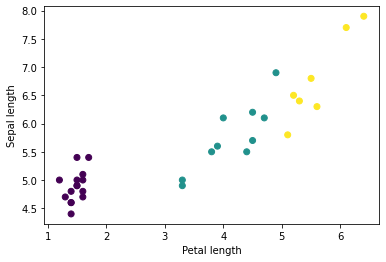

In [19]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

모델 구축 단계를 단순화하기 위해, 특성 딕셔너리를 `(batch_size, num_features)`의 형태를 가지는 단일 배열로 다시 구성하는 함수를 생성합니다.

이 함수는 텐서의 리스트(list)로부터 값을 취하고 특정한 차원으로 결합된 텐서를 생성하는 [tf.stack](https://www.tensorflow.org/api_docs/python/tf/stack) 메서드(method)를 사용합니다.

In [22]:
features.values() #특성별로 뽑혀나옴
tf.stack(list(features.values()), axis=1) #특성만 모아줌

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[5. , 2.3, 3.3, 1. ],
       [6.8, 3. , 5.5, 2.1],
       [5.1, 3.8, 1.6, 0.2],
       [6.1, 2.8, 4. , 1.3],
       [4.6, 3.2, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [4.8, 3.1, 1.6, 0.2],
       [6.4, 3.2, 5.3, 2.3],
       [4.8, 3. , 1.4, 0.3],
       [5.6, 2.5, 3.9, 1.1],
       [5.5, 2.6, 4.4, 1.2],
       [4.9, 2.4, 3.3, 1. ],
       [5. , 3.2, 1.2, 0.2],
       [7.7, 3. , 6.1, 2.3],
       [4.9, 3.1, 1.5, 0.1],
       [5. , 3.4, 1.5, 0.2],
       [5.7, 2.8, 4.5, 1.3],
       [6.1, 2.9, 4.7, 1.4],
       [5.4, 3.9, 1.7, 0.4],
       [5.5, 2.4, 3.8, 1.1],
       [6.5, 3. , 5.2, 2. ],
       [4.4, 2.9, 1.4, 0.2],
       [5.4, 3.7, 1.5, 0.2],
       [5.8, 2.7, 5.1, 1.9],
       [6.3, 3.4, 5.6, 2.4],
       [6.2, 2.2, 4.5, 1.5],
       [4.7, 3.2, 1.6, 0.2],
       [5. , 3.5, 1.6, 0.6],
       [4.6, 3.4, 1.4, 0.3],
       [6.9, 3.1, 4.9, 1.5],
       [7.9, 3.8, 6.4, 2. ],
       [4.7, 3.2, 1.3, 0.2]], dtype=float32)>

In [23]:
def pack_features_vector(features, labels):
  """특성들을 단일 배열로 묶습니다."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

그 후 각 `(features,label)`쌍의 특성을 훈련 데이터 세트에 쌓기위해 [tf.data.Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/dataset/map) 메서드를 사용합니다. 

In [24]:
train_dataset = train_dataset.map(pack_features_vector)

데이터셋의 특성 요소는 이제 형태가 `(batch_size, num_features)`인 배열입니다. 첫 5개행의 샘플을 살펴봅시다.

In [25]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[7.7 3.8 6.7 2.2]
 [6.1 3.  4.9 1.8]
 [6.3 3.3 4.7 1.6]
 [4.8 3.  1.4 0.3]
 [6.  3.  4.8 1.8]], shape=(5, 4), dtype=float32)


### 모델 타입 선정

### 왜 모델을 사용해야하는가?

 *[모델](https://developers.google.com/machine-learning/crash-course/glossary#model)* 은 특성(feature)과 레이블(label) 과의 관계입니다. 붓꽃 분류 문제에서 모델은 측정된 꽃받침과 꽃잎 사이의 관계를 정의하고 붓꽃의 품종을 예측합니다. 몇 가지 간단한 모델은 몇 줄의 대수학으로 표현할 수 있으나, 복잡한 머신러닝 모델은 요약하기 힘든 굉장히 많은 수의 매개변수를 가지고 있습니다.

머신러닝을 사용하지 않고 4가지의 특성 사이의 관계를 결정하고 붓꽃을 품종을 예측하실 수 있나요? 즉, 특정 품종의 꽃받침과 꽃잎과의 관계를 정의할 수 있을 정도로 데이터셋을 분석했다면, 전통적인 프로그래밍 기술(예를 들어 굉장히 많은 조건문)을 사용하여 모델은 만들 수 있으신가요? 더 복잡한 데이터셋에서 이는 불가능에 가까울 수 있습니다. 잘 구성된 머신러닝은 사용자를 위한 모델을 결정합니다. 만약 충분히 좋은 샘플을 잘 구성된 머신러닝 모델에 제공한다면, 프로그램은 사용자를 위한 특성 간의 관계를 이해하고 제공합니다. 

### 모델 선정

이제 학습을 위한 모델의 종류를 선정해야합니다. 여러 종류의 모델이 있고, 이를 선택하는 것은 많은 경험이 필요합니다. 이번 튜토리얼에서는 붓꽃 분류 문제를 해결하기위해 *[신경망(neural network)](https://developers.google.com/machine-learning/glossary/#neural_network)* 모델을 사용하겠습니다. 신경망 모델은 특성과 레이블 사이의 복잡한 관계를 찾을 수 있습니다. 신경망은 하나 또는 그 이상의 *[은닉층(hidden layer)](https://developers.google.com/machine-learning/glossary/#hidden_layer)*으로 구성된 그래프입니다. 각각의 은닉층은 하나 이상의 *[뉴런(neuron)](https://developers.google.com/machine-learning/glossary/#neuron)*으로 구성되어있습니다. 몇가지 신경망의 범주가 있으며, 이번 튜토리얼에서는 *[밀집(dense) 또는 완전 연결 신경망(fully-connected neural network)](https://developers.google.com/machine-learning/glossary/#fully_connected_layer)*를 사용합니다: 완전 연결 신경망(fully-connected neural network)은 하나의 뉴런에 이전층의 *모든* 뉴런의 입력을 받는 신경망입니다. 예를 들어, 그림 2는 입력층, 2개의 은닉층, 그리고 출력층으로 구성된 완전 연결 신경망입니다. 

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png"
         alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">
  </td></tr>
  <tr><td align="center">
    <b>그림 2.</b> 특성, 은닉층, 예측으로 구성된 신경망<br/>&nbsp;
  </td></tr>
</table>

그림 2의 모델이 훈련된 다음 레이블 되어있지 않은 데이터를 제공했을때, 모델은 주어진 데이터의 3가지(주어진 레이블의 개수) 예측을 출력합니다. 이러한 예측은 *[추론(inference)](https://developers.google.com/machine-learning/crash-course/glossary#inference)* 이라고 불립니다. 이 샘플에서 출력의 합은 1.0입니다. 그림 2에서 예측은 *Iris setosa* `0.02`, *Iris versicolor* `0.95`, *Iris virginica*에 `0.03`로 주어집니다. 이는 모델이 95%의 확률로 주어진 데이터를 *Iris versicolor*로 예측한다는 것을 의미합니다. 

### 케라스를 사용한 모델 생성

텐서플로의 [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) API는 모델과 층을 생성하기 위한 풍부한 라이브러리를 제공합니다. 케라스가 구성 요소를 연결하기 위한 복잡함을 모두 처리해 주기 때문에 모델을 구축하고 실험하는 것이 쉽습니다.

[tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)은 여러 층을 연이어 쌓은 모델입니다. 이 구조는 층의 인스턴스를 취하며, 아래의 경우 각 층당 10개의 노드(node)를 가지는 2개의 [완전 연결((Dense) 층](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)과 3개의 예측(레이블의 수) 노드를 가지는 출력 층으로 구성되어있습니다. 첫 번째 층의 `input_shape` 매개변수는 데이터셋의 특성의 수와 관계있습니다.

In [26]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # 입력의 형태가 필요합니다.
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

*[활성화 함수(activation function)](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)*는 각 층에서 출력의 형태를 결정합니다. 이러한 비선형성은 중요하며, 활성화 함수가 없는 모델은 하나의 층과 동일하다고 생각할 수 있습니다. 사용 가능한 [활성화 함수](https://www.tensorflow.org/api_docs/python/tf/keras/activations)는 많지만, [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU)가 은닉층에 주로 사용됩니다. 

이상적인 은닉층과 뉴런의 개수는 문제와 데이터셋에 의해 좌우됩니다. 머신러닝의 여러 측면과 마찬가지로, 최적의 신경망 타입을 결정하는 것은 많은 경험과 지식이 필요합니다. 경험을 토대로 보면 은닉층과 뉴런의 증가는 전형적으로 강력한 모델을 생성하므로, 모델을 효과적으로 훈련시키기 위해서 더 많은 데이터를 필요로 합니다.

### 모델 사용

이 모델이 특성의 배치에 대해 수행하는 작업을 간단히 살펴봅시다. 

In [27]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-3.7213123 , -1.4927921 ,  0.51361203],
       [-2.9412513 , -1.2853856 ,  0.39241338],
       [-3.0184746 , -1.4481488 ,  0.35885918],
       [-2.2663825 , -1.6762122 ,  0.09506218],
       [-2.8893065 , -1.2773488 ,  0.3766446 ]], dtype=float32)>

각 샘플은 각 클래스에 대한 [로짓(logit)](https://developers.google.com/machine-learning/crash-course/glossary#logits)을 반환합니다. 

이 로짓(logit)을 각 클래스에 대한 확률로 변환하기 위하서 [소프트맥스(softmax)](https://developers.google.com/machine-learning/crash-course/glossary#softmax) 함수를 사용하겠습니다.

In [28]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.01260357, 0.11703823, 0.87035817],
       [0.02917278, 0.15279572, 0.8180315 ],
       [0.0284894 , 0.13698311, 0.8345275 ],
       [0.0745681 , 0.13454293, 0.79088897],
       [0.0310389 , 0.15558605, 0.81337506]], dtype=float32)>

`tf.argmax`는 예측된 값 중 가장 큰 확률(원하는 클래스)을 반환합니다. 하지만 모델이 아직 훈련되지 않았으므로 이는 좋은 예측이 아닙니다.

In [29]:
print("  예측: {}".format(tf.argmax(predictions, axis=1)))
print("레이블: {}".format(labels))

  예측: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
레이블: [2 2 1 0 2 2 1 1 2 0 1 2 0 0 1 0 0 1 1 2 1 2 0 0 0 0 0 1 1 1 0 0]


### 모델 훈련하기

*[훈련 단계](https://developers.google.com/machine-learning/crash-course/glossary#training)* 는 모델이 점진적으로 최적화되거나 데이터셋을 학습하는 머신러닝의 과정입니다. 훈련의 목적은 미지의 데이터를 예측하기 위해, 훈련 데이터 세트의 구조에 대해서 충분히 학습하는 것입니다. 만약 모델이 훈련 데이터 세트에 대해서 과하게 학습된다면 오직 훈련 데이터 세트에 대해서 작동할 것이며, 일반화되기 힘들 것입니다. 이러한 문제를 *[과대적합(overfitting)](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)* 이라고 합니다. 이는 마치 문제를 이해하고 해결한다기보다는 답을 기억하는 것이라고 생각할 수 있습니다. 

붓꽃 분류 문제는 *[지도 학습(supervised machine learning)](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)* 의 예시 중 하나입니다.: 지도학습은 모델이 레이블을 포함한 훈련 데이터로부터 학습됩니다. *[비지도 학습(unsupervised machine learning)](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)* 에서는 훈련 데이터가 레이블을 포함하고 있지 않습니다. 대신에 모델은 특성 간의 패턴을 찾습니다. 

### 손실 함수와 그래디언트 함수 정의하기

훈련과 평가단계에서 모델의 *[손실(loss)](https://developers.google.com/machine-learning/crash-course/glossary#loss)*을 계산해야 합니다. 손실은 모델의 예측이 원하는 레이블과 얼마나 일치하는지, 또한 모델이 잘 작동하는지에 대한 척도로 사용됩니다. 이 값을 최소화하고, 최적화 해야합니다.

모델의 손실은 `tf.keras.losses.categorical_crossentropy` 함수를 사용해 계산할 것입니다. 이 함수는 모델의 클래스(레이블)과 예측된 값(로짓)을 입력받아 샘플의 평균 손실을 반환합니다.

In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [31]:
def loss(model, x, y):
  y_ = model(x)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels)
print("손실 테스트: {}".format(l))

손실 테스트: 1.792086124420166


모델을 최적화하기 위해 사용되는 *[그래디언트(gradient)](https://developers.google.com/machine-learning/crash-course/glossary#gradient)*를 계산하기 위해 [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) 컨텍스트를 사용합니다.

In [32]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### 옵티마이저 생성 

*[옵티마이저(optimizer)](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)*는 `손실` 함수를 최소화하기 위해 계산된 그래디언트를 모델의 변수에 적용합니다. 손실 함수를 구부러진 곡선의 표면(그림 3)으로 생각할 수 있으며, 이 함수의 최저점을 찾고자 합니다. 그래디언트는 가장 가파른 상승 방향을 가리키며 따라서 반대 방향으로 이동하는 여행을 합니다. 각 배치마다의 손실과 기울기를 반복적으로 계산하여 훈련과정 동안 모델을 조정합니다. 점진적으로, 모델은 손실을 최소화하기 위해 가중치(weight)와 편향(bias)의 최적의 조합을 찾아냅니다. 손실이 낮을수록 더 좋은 모델의 예측을 기대할 수 있습니다.

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b> 그림 3.</b> 3차원 공간에 대한 최적화 알고리즘 시각화.<br/>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

텐서플로는 훈련을 위해 사용 가능한 여러종류의 [최적화 알고리즘](https://www.tensorflow.org/api_guides/python/train)을 가지고 있습니다. 이번 모델에서는 *[확률적 경사 하강법(stochastic gradient descent, SGD)](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* 을 구현한 [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)를 사용하겠습니다. `learning_rate`은 경사하강 과정의 크기를 나타내는 매개변수이며, 더 나은 결과를 위해 조절가능한 *하이퍼파라미터(hyperparameter)* 입니다. 

옵티마이저(optimizer)를 설정합니다.

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

이를 사용해 한 번의 최적화 단계를 계산하기 위해 사용합니다. 

In [43]:
loss_value, grads = grad(model, features, labels)

print("단계: {}, 초기 손실: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables)) # w = w -learning_rate*dw

print("단계: {},      손실: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels).numpy()))

단계: 9, 초기 손실: 0.8197178840637207
단계: 10,      손실: 0.8005514144897461


### 훈련 루프

모든 사항이 갖춰졌으므로 모델을 훈련할 준비가 되었습니다! 훈련 루프는 더 좋은 예측을 위해 데이터셋을 모델로 제공합니다. 다음의 코드 블럭은 아래의 훈련 단계를 작성한 것입니다. 

1. 각 *에포크(epoch)* 반복. 에포크는 데이터셋을 통과시키는 횟수입니다. 
2. 에포크 내에서, *특성* (`x`)와 *레이블* (`y`)가 포함된 훈련 데이터 세트에 있는 샘플을 반복합니다.
3. 샘플의 특성을 사용하여 결과를 예측 하고 레이블과 비교합니다. 예측의 부정확도를 측정하고 모델의 손실과 그래디언트를 계산하기 위해 사용합니다. 
4. 모델의 변수를 업데이트하기 위해 `옵티마이저`를 사용합니다. 
5. 시각화를 위해 몇가지 값들을 저장합니다.
6. 각 에포크를 반복합니다.

`num_epochs` 변수는 데이터셋의 반복 횟수입니다. 직관과는 반대로, 모델을 길게 학습하는 것이 더 나은 모델이 될 것이라고 보장하지 못합니다. `num_epochs`는 조정가능한 *[하이퍼파라미터(hyperparameter)](https://developers.google.com/machine-learning/glossary/#hyperparameter)* 입니다. 적절한 횟수를 선택하는 것은 많은 경험과 직관을 필요로 합니다. 

In [44]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  for x, y in train_dataset:
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    epoch_loss_avg(loss_value)  

    epoch_accuracy(y, model(x))

  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("에포크 {:03d}: 손실: {:.3f}, 정확도: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

에포크 000: 손실: 0.832, 정확도: 63.333%
에포크 050: 손실: 0.084, 정확도: 98.333%
에포크 100: 손실: 0.057, 정확도: 98.333%
에포크 150: 손실: 0.050, 정확도: 99.167%
에포크 200: 손실: 0.048, 정확도: 98.333%


### 시간에 따른 손실함수 시각화

모델의 훈련 과정을 출력하는 것도 도움이 되지만, 훈련 과정을 직접 보는 것이 더 도움이 되곤합니다. [텐서보드(tensorboard)](https://www.tensorflow.org/guide/summaries_and_tensorboard)는 텐서플로에 패키지 되어있는 굉장히 유용한 시각화 툴입니다. 하지만 `matplotlib` 모듈을 사용하여 일반적인 도표를 출력할 수 있습니다.

이 도표를 해석하는 것은 여러 경험이 필요하지만, 결국 모델을 최적화하기 위해 *손실* 이 내려가고 *정확도* 가 올라가는 것을 원합니다.

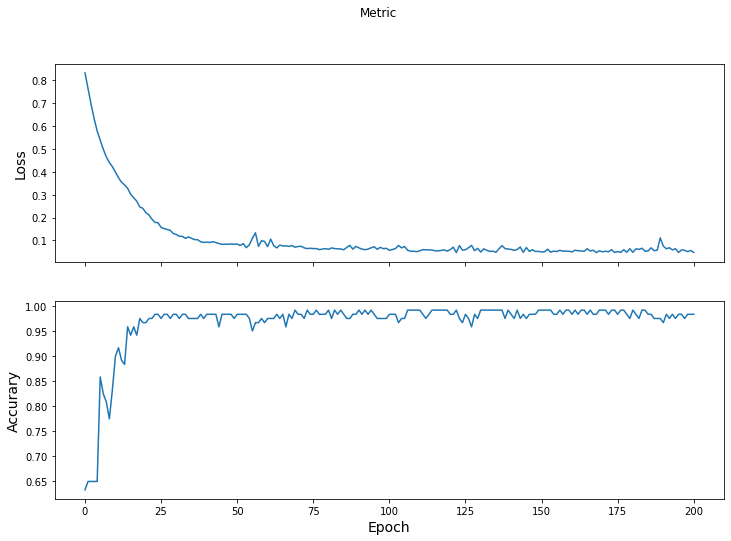

In [45]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Metric')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accurary", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## 모델 유효성 평가

이제 모델은 훈련되었습니다. 모델의 성능에 대한 몇가지 통계를 얻을 수 있습니다. 

*평가(Evaluating)*는 모델이 예측을 얼마나 효과적으로 수행하는지 결정하는 것을 의미합니다. 붓꽃 분류 모델의 유효성을 결정하기 위해, 몇가지 꽃잎과 꽃받침 데이터를 통과시키고 어떠한 품종을 예측하는지 확인합니다. 그 후 실제 품종과 비교합니다. 예를 들어, 절반의 데이터를 올바르게 예측한 모델의 *[정확도](https://developers.google.com/machine-learning/glossary/#accuracy)* 는 `0.5`입니다. 그림 4는 조금 더 효과적인 모델입니다. 5개의 예측 중 4개를 올바르게 예측하여 80% 정확도를 냅니다.

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4" >
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">샘플 특성</th>
    <th colspan="1">레이블</th>
    <th colspan="1" >모델 예측</th>
  </tr>
  <tr>
    <td>5.9</td><td>3.0</td><td>4.3</td><td>1.5</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td><td>3.1</td><td>5.4</td><td>2.1</td><td align="center">2</td><td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td><td>3.3</td><td>1.7</td><td>0.5</td><td align="center">0</td><td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td><td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td><td>2.5</td><td>4.0</td><td>1.3</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">
    <b>그림 4.</b> 80% 정확도 붓꽃 분류기.<br/>&nbsp;
  </td></tr>
</table>

### 테스트 데이터 세트 설정

모델을 평가하는 것은 모델을 훈련하는 것과 유사합니다. 가장 큰 차이는 훈련 데이터가 아닌 *[테스트 데이터 세트](https://developers.google.com/machine-learning/crash-course/glossary#test_set)* 를 사용했다는 것입니다. 공정하게 모델의 유효성을 평가하기 위해, 모델을 평가하기 위한 샘플은 반드시 훈련 데이터와 달라야합니다. 

테스트 데이터 세트를 설정하는 것은 훈련 데이터 세트를 설정하는 것과 유사합니다. CSV 파일을 다운로드하고 값을 파싱합니다. 그 후 셔플은 적용하지 않습니다.

In [46]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [37]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

### 테스트 데이터 세트를 사용한 모델 평가

훈련 단계와는 다르게 모델은 테스트 데이터에 대해서 오직 한 번의 [에포크](https://developers.google.com/machine-learning/glossary/#epoch)를 진행합니다. 다음의 코드 셀은 테스트 셋에 있는 샘플에 대해 실행하고 실제 레이블과 비교합니다. 이는 전체 테스트 데이터 세트에 대한 정확도를 측정하는데 사용됩니다.

In [38]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("테스트 세트 정확도: {:.3%}".format(test_accuracy.result()))

테스트 세트 정확도: 96.667%


마지막 배치에서 모델이 올바르게 예측한 것을 확인할 수 있습니다. 

In [39]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]])>

## 훈련된 모델로 예측하기

이제 붓꽃을 분류하기 위해 완벽하지는 않지만 어느 정도 검증된 모델을 가지고 있습니다. 훈련된 모델을 사용하여 [레이블 되지 않은 데이터](https://developers.google.com/machine-learning/glossary/#unlabeled_example)를 예측해봅시다.

실제로는 레이블 되지 않은 샘플들은 여러 소스(앱, CSV 파일, 직접 제공 등)로부터 제공될 수 있습니다. 지금은 레이블을 예측하기 위해 수동으로 3개의 레이블 되지 않은 샘플을 제공하겠습니다.  레이블은 다음과 같은 붓꽃 이름으로 매핑되어있습니다.
* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

In [40]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("샘플 {} 예측: {} ({:4.1f}%)".format(i, name, 100*p))

샘플 0 예측: Iris setosa (99.6%)
샘플 1 예측: Iris versicolor (99.8%)
샘플 2 예측: Iris virginica (99.6%)
